In [1]:
import time
import re
import MySQLdb

import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne import layers, init, nonlinearities
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
%matplotlib inline

#from dssm import build_multi_dssm
from dataset_tools import *
from dssm import build_multi_dssm
from string_tools import *

### Load DSSM params and user's papers (raw data)

In [2]:
loader = np.load('../data/datasets/dataset-pasi.npz')
ngrams = loader['ngrams']
num_entries = loader['num_entries'][0]

In [3]:
def list2paper(l, r_index=None, r_author=None, r_title=None, r_abstract=None, r_cite=None):
    """
    Transform a raw data paper formatted as a list into dict
    """
    p = {'index': None, 'authors': [], 'title': None, 'abstract': None, 'citations': []}
    
    if r_index is None:
        r_index = re.compile('^#index(.*)')
    if r_author is None:
        r_author = re.compile('^#@(.*)')
    if r_title is None:
        r_title = re.compile('^#\*(.*)')
    if r_abstract is None:
        r_abstract = re.compile('^#!(.*)')
    if r_cite is None:
        r_cite = re.compile('^#%(.*)')
        
    for s in l:
        m_index = r_index.match(s)
        if m_index is not None:
            p['index'] = m_index.group(1)
        
        m_author = r_author.match(s)
        if m_author is not None:
            p['authors'] = [a.strip() for a in m_author.group(1).split(',')]
        
        m_title = r_title.match(s)
        if m_title is not None:
            p['title'] = m_title.group(1)
        
        m_abstract = r_abstract.match(s)
        if m_abstract is not None:
            p['abstract'] = m_abstract.group(1)
        
        m_cite = r_cite.match(s)
        if m_cite is not None:
            p['citations'].append(m_cite.group(1))
    
    return p

In [4]:
def retrieve_papers(input_file, author_name):
    """
    Read input file and return a list of dicts
    """
    r_index = re.compile('^#index(.*)')
    r_author = re.compile('^#@(.*)')
    r_title = re.compile('^#\*(.*)')
    r_abstract = re.compile('^#!(.*)')
    r_cite = re.compile('^#%(.*)')

    # Split result into a list of lists (each sublist is a paper)
    papers = []
    with open(input_file, 'r') as f:
        content = f.readlines()
        p = []
        for l in content:
            if l.strip() != '':
                p.append(l)
            else:
                papers.append(p)
                p = [] 
    
    papers = [list2paper(l) for l in papers]
    
    author_papers = []
    papers_without_abstract = []
    
    for p in papers:
        if author_name in p['authors']:
            if p['abstract'] is not None:
                author_papers.append(p)
            else:
                papers_without_abstract.append(p)
    
    return author_papers, papers_without_abstract

In [5]:
def user_papers_from_raw(user_papers, ngrams=None, verbosity=1):
    """
    Compute the user's papers features
    """
    sh = StringHasher()
    sc = StringCleaner()
    
    if ngrams is None:
        # Generate author's vocabulary
        tokens = generate_user_vocab(user_papers)

        # Initiate the ngrams (specific to the author)
        sh.init_ngrams(tokens)
    else:
        sh.load_ngrams(ngrams)
    
    # Hash user's papers' titles and abstracts
    papers_feat = {}
    total = len(user_papers)
    i = 1
    start_time = time.time()
    for p in user_papers:
        title = sc.clean_string(p['title'])
        abstract = sc.clean_string(p['abstract'])
        to_hash = title + " " + abstract
        papers_feat[p['index']] = sh.hash(to_hash)
        if verbosity > 1 and i % 100 == 0:
            print("Paper %d over %d" % (i, total))
        i += 1
    
    return papers_feat

In [6]:
user_papers_raw, _ = retrieve_papers('../data/pasi_papers.txt', 'Gabriella Pasi')

papers_feat = user_papers_from_raw(user_papers_raw, ngrams)

### Build DSSM, load params and compute user's papers projections

In [40]:
num_samples = 1
dssm_loader = np.load('../data/outputs/output-pasi.npz')
dssm_struct = dssm_loader['dssm_struct'].reshape(1, -1)[0, 0]
num_hid1 = dssm_struct['num_hid1']
num_hid2 = dssm_struct['num_hid2']
num_out = dssm_struct['num_out']
gamma = 500.0 # dssm_struct['gamma']

In [41]:
input_var = T.matrix()
dssm_values = dssm_loader['dssm']
network = build_multi_dssm(input_var=input_var, 
                                      num_samples=num_samples, 
                                      num_entries=num_entries,
                                      num_ngrams=len(ngrams), 
                                      num_hid1=num_hid1, 
                                      num_hid2=num_hid2, 
                                      num_out=num_out)
lasagne.layers.set_all_param_values(network, dssm_values)
prediction = lasagne.layers.get_output(network, deterministic=True)
output = prediction / prediction.norm(L=2)

In [42]:
f = theano.function([input_var], output)

In [43]:
user_papers = [f(x.reshape(1, -1))[0] for _, x in papers_feat.items()]

### Compute scores for "new" papers

In [44]:
good_papers = [
    {
        'title': "Statistical Language Models for Information Retrieval A Critical Review",
        'abstract': 'Abstract Statistical language models have recently been successfully applied to many information retrieval problems. A great deal of recent work has shown that statistical language models not only lead to superior empirical performance, but also facilitate parameter tuning and open up possibilities for modeling nontraditional retrieval problems. In general, statistical language models provide a principled way of modeling various kinds of retrieval problems. The purpose of this survey is to systematically and critically review the existing work in applying statistical language models to information retrieval, summarize their contributions, and point out outstanding challenges.',
    },
    {
        'title': 'Personalized information delivery: an analysis of information filtering methods',
        'abstract': 'With the increasing availability of information in electronic form, it becomes more important and feasible to have automatic methods to filter information. Research organizations generate large amounts of information, which can include departmental and technical memoranda, announcements of meetings and conferences, and minutes from meetings. This volume of information makes it difficult to keep employees apprised of all relevant work. Furthermore, only a small fraction of the available information will actually be relevant to any particular employee within an organization that covers a variety of areas. Thus, there is the problem of determining what information is of interest to the employee, while minimizing the amount of search through irrelevant information. This research tested several information-retrieval methods for filtering technical memos. Filtering of information is not a new concept, nor is it one that is limited to electronic documents. When we read standard paper texts, information filtering occurs. We only buy certain magazines, since other magazines may contain information that is redundant or irrelevant to our interests. In this way, we are filtering out some of the large amount of information to which we have access. Within any particular magazine, we also choose articles that appear relevant to our interests. Thus, when people are engaged in any sort of acquisition of information, they continually filter information. With the advent of electronic presentation of information, some of that filtering need no longer be done by us, but could be done automatically by the system that presents the information.',
    },
    {
        'title': 'Personalizing search via automated analysis of interests and activities',
        'abstract': 'We formulate and study search algorithms that consider a user\'s prior interactions with a wide variety of content to personalize that user\'s current Web search. Rather than relying on the unrealistic assumption that people will precisely specify their intent when searching, we pursue techniques that leverage implicit information about the user\'s interests. This information is used to re-rank Web search results within a relevance feedback framework. We explore rich models of user interests, built from both search-related information, such as previously issued queries and previously visited Web pages, and other information about the user such as documents and email the user has read and created. Our research suggests that rich representations of the user and the corpus are important for personalization, but that it is possible to approximate these representations and provide efficient client-side algorithms for personalizing search. We show that such personalization algorithms can significantly improve on current Web search.',
    },
    {
        'title': 'Information retrieval based on fuzzy associations',
        'abstract': 'The aim of the present paper is to propose a fuzzy set model for information retrieval and to develop methods and algorithms for fuzzy information retrieval based on the fuzzy set model. A process of information retrieval is represented as a diagram that consists of three components. Each component has its inherent fuzziness. As typical examples for describing the three components, we consider a fuzzy association as a generalization of a fuzzy thesaurus for the first component, a fuzzy inverted index for the second component, and a fuzzy filter for the third component. Efficient algorithms for fuzzy retrieval on large scale bibliographic databases are developed. The significance of the present method is that current techniques in researches of bibliographic databases without fuzzy sets are studied in the framework of fuzzy sets and their implications are made clear using the model herein.',
    },
    {
        'title': 'Fuzzy information systems: managing uncertainty in databases and information retrieval systems',
        'abstract': 'Querying for information is a commonality between databases and information retrieval systems. For both areas, there are a variety of issues relative to representation of uncertainty and its retrieval. This paper reviews these issues for both types of systems and discusses potential future directions.',
    },
]

bad_papers = [
    {
        'title': "Neural-network-based fuzzy logic control and decision system",
        'abstract': "A general neural-network (connectionist) model for fuzzy logic control and decision systems is proposed. This connectionist model, in the form of feedforward multilayer net, combines the idea of fuzzy logic controller and neural-network structure and learning abilities into an integrated neural-network-based fuzzy logic control and decision system. A fuzzy logic control decision network is constructed automatically by learning the training examples itself. By combining both unsupervised (self-organized) and supervised learning schemes, the learning speed converges much faster than the original backpropagation learning algorithm. The connectionist structure avoids the rule-matching time of the inference engine in the traditional fuzzy logic system. Two examples are presented to illustrate the performance and applicability of the proposed model."
    },
    {
        'title': "A hierarchical type-2 fuzzy logic control architecture for autonomous mobile robots",
        'abstract': "Autonomous mobile robots navigating in changing and dynamic unstructured environments like the outdoor environments need to cope with large amounts of uncertainties that are inherent of natural environments. The traditional type-1 fuzzy logic controller (FLC) using precise type-1 fuzzy sets cannot fully handle such uncertainties. A type-2 FLC using type-2 fuzzy sets can handle such uncertainties to produce a better performance. In this paper, we present a novel reactive control architecture for autonomous mobile robots that is based on type-2 FLC to implement the basic navigation behaviors and the coordination between these behaviors to produce a type-2 hierarchical FLC. In our experiments, we implemented this type-2 architecture in different types of mobile robots navigating in indoor and outdoor unstructured and challenging environments. The type-2-based control system dealt with the uncertainties facing mobile robots in unstructured environments and resulted in a very good performance that outperformed the type-1-based control system while achieving a significant rule reduction compared to the type-1 system."
    },
    {
        'title': "Data mining in bioinformatics using Weka",
        'abstract': "Summary: The Weka machine learning workbench provides a general-purpose environment for automatic classification, regression, clustering and feature selection—common data mining problems in bioinformatics research. It contains an extensive collection of machine learning algorithms and data pre-processing methods complemented by graphical user interfaces for data exploration and the experimental comparison of different machine learning techniques on the same problem. Weka can process data given in the form of a single relational table. Its main objectives are to (a) assist users in extracting useful information from data and (b) enable them to easily identify a suitable algorithm for generating an accurate predictive model from it."
    },
    {
        'title': "A comparison of normalization methods for high density oligonucleotide array data based on variance and bias",
        'abstract': "Motivation: When running experiments that involve multiple high density oligonucleotide arrays, it is important to remove sources of variation between arrays of non-biological origin. Normalization is a process for reducing this variation. It is common to see non-linear relations between arrays and the standard normalization provided by Affymetrix does not perform well in these situations. Results: We present three methods of performing normalization at the probe intensity level. These methods are called complete data methods because they make use of data from all arrays in an experiment to form the normalizing relation. These algorithms are compared to two methods that make use of a baseline array: a one number scaling based algorithm and a method that uses a non-linear normalizing relation by comparing the variability and bias of an expression measure. Two publicly available datasets are used to carry out the comparisons. The simplest and quickest complete data method is found to perform favorably. Availability: Software implementing all three of the complete data normalization methods is available as part of the R package Affy, which is a part of the Bioconductor project http://www.bioconductor.org."
    },
    {
        'title': "MEGA: Molecular evolutionary genetics analysis software for microcomputers",
        'abstract': "A computer program package called MEGA has been developed for estimating evolutionary distances, reconstructing phylogenetic trees and computing basic statistical quantities from molecular data. It is written in C++ and is intended to be used on IBM and IBM-compatible personal computers. In this program, various methods for estimating evolutionary distances from nucleotide and amino acid sequence data, three different methods of phylogenetic inference (UPGMA, neighborjoining and maximum parsimony) and two statistical tests of topological differences are included. For the maximum parsimony method, new algorithms of branch-and-bound and heuristic searches are implemented. In addition, MEGA computes statistical quantities such as nucleotide and amino acid frequencies, transition/transversion biases, codon frequencies (codon usage tables), and the number of variable sites in specified segments in nucleotide and amino acid sequences. Advanced on-screen sequence data and phylogenetictree editors facilitate publication-quality outputs with a wide range of printers. Integrated and interactive designs, on-line context-sensitive helps, and a text-file editor make MEGA easy to use. © 1994 Oxford University Press."
    },
]

In [45]:
def hash_paper(p_title, p_abstract, ngrams):
    sh = StringHasher()
    sc = StringCleaner()
    
    sh.load_ngrams(ngrams)
    
    title = sc.clean_string(p_title)
    abstract = sc.clean_string(p_abstract)
    to_hash = title + " " + abstract
    p_feats = sh.hash(to_hash)
    
    return p_feats

In [46]:
def get_similarities(paper, user_papers):
    return np.array([np.dot(paper, y)[0] for y in user_papers])

In [47]:
def get_probas(paper, user_papers, gamma=500.0):
    similarities = get_similarities(paper, user_papers)
    
    def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    return softmax(gamma * similarities)

In [48]:
import pandas as pd

def results(papers):
    sims, sims_d = [], []
    for i, p in enumerate(papers):
        paper = hash_paper(p['title'], p['abstract'], ngrams)
        paper = f(paper.reshape(1, -1))
        sim = pd.Series(get_similarities(paper, user_papers))
        sims.append(sim)
        sims_d.append(sim.describe())
    return sims, sims_d

goods, goods_d = results(good_papers)
bads, bads_d = results(bad_papers)

In [49]:
gp = bad_papers[2]
gp = hash_paper(gp['title'], gp['abstract'], ngrams)
gp = f(gp.reshape(1, -1))
sims = get_similarities(gp, user_papers)
sorted(sims)

[-0.61656166024812364,
 -0.45310333158060856,
 0.76246740006492575,
 0.77347681114658795,
 0.86777271108859244,
 0.89669839690328634,
 0.90184236056886347,
 0.90268857066896446,
 0.90820881873754944,
 0.9088455474338748,
 0.91017644384897478,
 0.91096347568200242,
 0.91134180450703295,
 0.91160349044177558,
 0.91240304666272687,
 0.91248839032509832,
 0.912554562751142,
 0.91369427392107916,
 0.91399901603196465,
 0.91418811220286089,
 0.91422128022117244,
 0.9142942870927786,
 0.91430395732200076,
 0.91439621100539747,
 0.9144128551415005,
 0.91453094936823964,
 0.9145646067929718,
 0.91470693505476919,
 0.91476686752065295,
 0.91482142505216135,
 0.91482943347054668,
 0.91484220606469147,
 0.91489036842036386,
 0.91496729294772994,
 0.9149737422152362,
 0.91497775673624937,
 0.91506948436604985,
 0.91512269284054681,
 0.91515357673070108,
 0.91516978548845151,
 0.91517094315436276,
 0.9153379659865899,
 0.91539559200280785,
 0.91546389002420347,
 0.91556955596121026,
 0.9155716037209

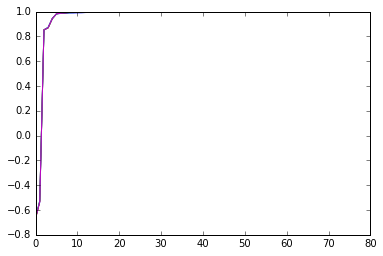

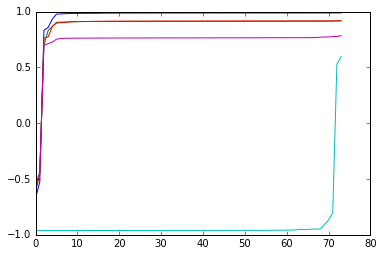

In [50]:
for i in range(5):
    plt.plot(sorted(goods[i]))
plt.show()

for i in range(5):
    plt.plot(sorted(bads[i]))
plt.show()